In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr

import numpy as np
from pathlib import Path
from tqdm.auto import tqdm

%matplotlib widget
import matplotlib.pyplot as plt

save_dir = Path("/work/pi_kandread_umass_edu/tss-ml/data/NA_WQP/")

polygons = gpd.read_file(save_dir/"metadata"/'site_basin_polygons.shp', engine="pyogrio", use_arrow=True)
polygons = polygons.set_index('wqp_id')

attributes = pd.read_csv(save_dir/"attributes"/"attributes.csv", index_col='index')

data = {}
nc_files = list((save_dir / "time_series").glob('*.nc'))
for f in tqdm(nc_files):
    with xr.open_dataset(f) as ds:
        means = ds.mean(dim='date')
        counts = ds.count(dim='date')
        
        # Combine metadata into a single dict
        combined_dict = {}
        for var in ds.variables:
            if var in means and var in counts:
                combined_dict[f"{var}_mean"] = means[var].values
                combined_dict[f"{var}_count"] = counts[var].values
                
        data[f.stem] = combined_dict       
nc_summary = pd.DataFrame.from_dict(data, orient='index')

metadata = polygons[['geometry']].join(attributes, how='inner').join(nc_summary,how='inner')


  0%|          | 0/741 [00:00<?, ?it/s]

In [2]:
file_path = save_dir/'metadata'/'site_lists'/'sites.txt'
metadata.reset_index()['index'].to_csv(file_path, header=False, index=False)

In [3]:
ignore_basins = ['USGS-09383100']
metadata_ignore = metadata.drop(ignore_basins)
file_path = save_dir/'metadata'/'site_lists'/'sites_rm_high_loss.txt'
metadata_ignore.reset_index()['index'].to_csv(file_path, header=False, index=False)

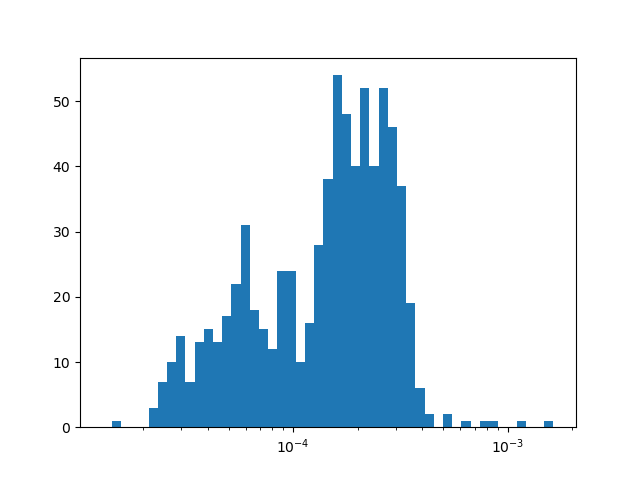

In [4]:
plt.close('all')
data = nc_summary['surface_runoff_sum_mean'].dropna()
min_val = data.min()*0.9
max_val = data.max()*1.1
log_bins = np.logspace(np.log10(min_val), np.log10(max_val), num=50) 
plt.hist(data, bins=log_bins)
plt.xscale('log')


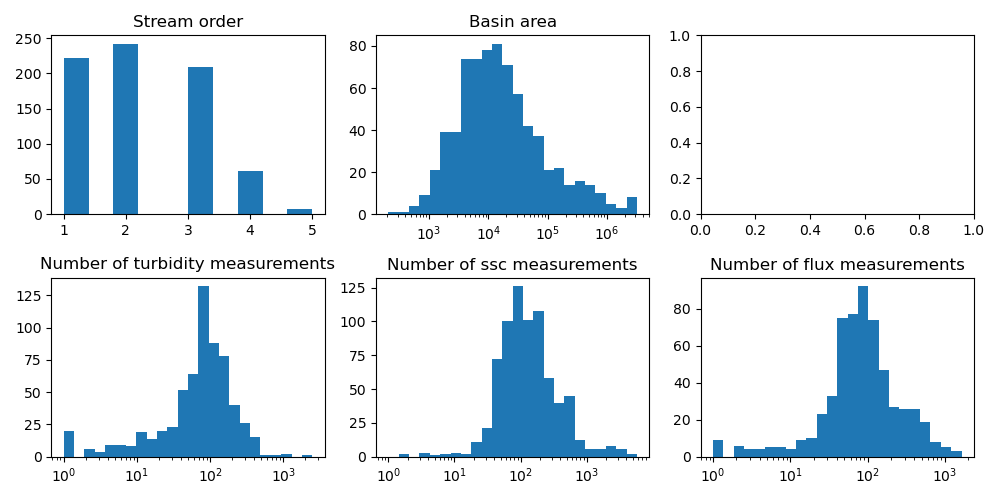

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,5))

axes[0,0].hist(metadata["order"])
axes[0,0].set_title("Stream order")

bins = np.logspace(np.log10(min(metadata["area"])),np.log10(max(metadata["area"])), 25)
axes[0,1].hist(metadata["area"], bins=bins)
axes[0,1].set_xscale("log")
axes[0,1].set_title("Basin area")

targets = ["turbidity","ssc","flux"]
for i, target in enumerate(targets):
    bins = np.logspace(0,np.log10(max(metadata[f"{target}_count"])), 25)
    axes[1,i].hist(metadata[f"{target}_count"],bins=bins)
    axes[1,i].set_xscale("log")
    axes[1,i].set_title(f"Number of {target} measurements")


plt.tight_layout()
plt.show()


In [ ]:
list(metadata)

In [ ]:
area = 10000 #km^2
feature = "ssc"
n_sat_obs = 50

mask = ((metadata["area"]>=area) & 
        (metadata[f"n_red_{feature}"]>= n_sat_obs))

print(np.sum(mask))
file_name = f"sites_{feature}_area{area}_n{n_sat_obs}.txt"
file_path = save_dir/"site_lists"/file_name
print(file_path)

# Save the Series to a text file with no delimiters or headers
# metadata.hybas[mask].to_csv(file_path, header=False, index=False)

metadata[mask].plot(alpha=0.2)



In [ ]:
pwd